<a href="https://colab.research.google.com/github/AbhirKarande/OCRandProductRecognition/blob/main/SiameseFewShot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!git clone https://github.com/AbhirKarande/OCRandProductRecognition.git

fatal: destination path 'OCRandProductRecognition' already exists and is not an empty directory.


In [ ]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

In [ ]:
import re
import numpy as np

def read_image(filename, byteorder='>'):
    with open(filename, 'rb') as f:
        buffer = f.read()

    # Find the header, width, height, and maxval using regex
    match = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer)

    if match is None:
        raise ValueError("Invalid image format or header not found.")

    header, width, height, maxval = match.groups()

    # Convert the image to a numpy array
    return np.frombuffer(buffer,
                         dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                         count=int(width)*int(height),
                         offset=len(header)
                         ).reshape((int(height), int(width)))


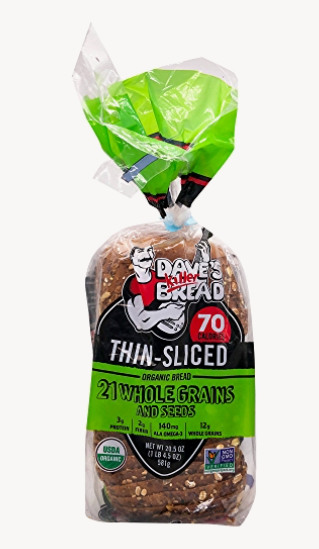

In [ ]:
Image.open("/content/OCRandProductRecognition/WholeFoodsTrainingImages/train/Dave's Killer Bread Organic Thin-sliced 21 Whole Grains and Seeds Bread/DavesKiller1.png")

In [ ]:
import os
from PIL import Image

def convert_png_to_pgm_directory(input_dir, output_dir):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate through the files in the input directory
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith('.png'):  # Process only PNG files
                png_path = os.path.join(root, file)
                pgm_filename = file[:-4] + '.pgm'  # Change file extension to .pgm
                pgm_path = os.path.join(output_dir, pgm_filename)

                # Convert PNG to PGM
                image = Image.open(png_path).convert('L')  # Convert to grayscale
                image.save(pgm_path)

# Example usage
input_dir = '/content/OCRandProductRecognition/WholeFoodsTrainingImages/train'
output_dir = 'path/to/output'
convert_png_to_pgm_directory(input_dir, output_dir)


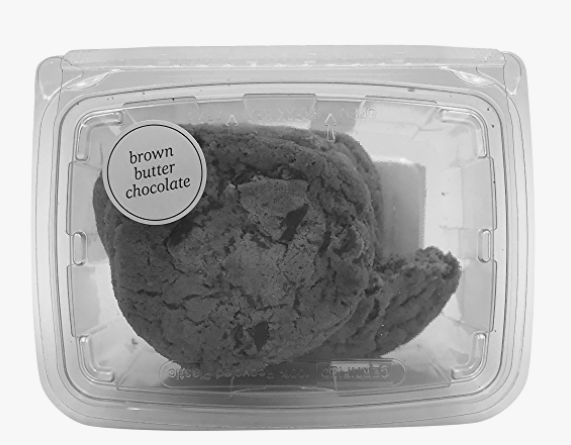

In [48]:
Image.open("/content/path/to/output/3.pgm")

In [49]:
import os
from PIL import Image

def convert_png_to_pgm_directory(root_dir, output_dir):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate through the subdirectories in the root directory
    for dir_name, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith('.png'):  # Process only PNG files
                png_path = os.path.join(dir_name, file)
                pgm_filename = file[:-4] + '.pgm'  # Change file extension to .pgm
                pgm_path = os.path.join(output_dir, pgm_filename)

                # Convert PNG to PGM
                image = Image.open(png_path).convert('L')  # Convert to grayscale
                image.save(pgm_path)

# Example usage
root_dir = '/content/OCRandProductRecognition/WholeFoodsTrainingImages/train'
output_dir = 'path/to/output/s1'

# Iterate through the 'train' subdirectory and its subdirectories
train_dir = os.path.join(root_dir, 'train')
convert_png_to_pgm_directory(train_dir, output_dir)

# Iterate through the other directories and their subdirectories
other_dirs = ['s1','s2', 's3', 's4']
for dir_name in other_dirs:
    sub_dir = os.path.join(root_dir, dir_name)
    output_dir = 'path/to/output/'+dir_name
    convert_png_to_pgm_directory(sub_dir, output_dir)


In [50]:
import os
import itertools
import numpy as np

def get_data(data_dir):
    x_genuine_pair = []
    y_genuine = []
    x_imposter_pair = []
    y_imposter = []

    # Gather the list of subdirectories
    subdirectories = [name for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name))]
    
    # Generate genuine pairs and assign labels as 1
    for sub_dir in subdirectories:
        images_dir = os.path.join(data_dir, sub_dir)
        image_files = [name for name in os.listdir(images_dir) if name.endswith('.pgm')]
        combinations = list(itertools.combinations(image_files, 2))
        x_genuine_pair.extend([[os.path.join(images_dir, img1), os.path.join(images_dir, img2)] for img1, img2 in combinations])
        y_genuine.extend([1] * len(combinations))

    # Generate imposter pairs and assign labels as 0
    for pair in itertools.combinations(subdirectories, 2):
        sub_dir1, sub_dir2 = pair
        images_dir1 = os.path.join(data_dir, sub_dir1)
        images_dir2 = os.path.join(data_dir, sub_dir2)
        image_files1 = [name for name in os.listdir(images_dir1) if name.endswith('.pgm')]
        image_files2 = [name for name in os.listdir(images_dir2) if name.endswith('.pgm')]
        x_imposter_pair.extend([[os.path.join(images_dir1, img1), os.path.join(images_dir2, img2)] for img1 in image_files1 for img2 in image_files2])
        y_imposter.extend([0] * (len(image_files1) * len(image_files2)))

    # Concatenate genuine and imposter pairs
    X = np.concatenate([x_genuine_pair, x_imposter_pair], axis=0)
    Y = np.concatenate([y_genuine, y_imposter], axis=0)

    return X, Y

# Example usage
data_dir = 'path/to/output'  # Directory containing the PGM images
X1, Y1 = get_data(data_dir)


In [56]:
print((X1))

[['path/to/output/s3/3.pgm' 'path/to/output/s3/1.pgm']
 ['path/to/output/s3/3.pgm' 'path/to/output/s3/5.pgm']
 ['path/to/output/s3/3.pgm' 'path/to/output/s3/4.pgm']
 ['path/to/output/s3/3.pgm' 'path/to/output/s3/2.pgm']
 ['path/to/output/s3/1.pgm' 'path/to/output/s3/5.pgm']
 ['path/to/output/s3/1.pgm' 'path/to/output/s3/4.pgm']
 ['path/to/output/s3/1.pgm' 'path/to/output/s3/2.pgm']
 ['path/to/output/s3/5.pgm' 'path/to/output/s3/4.pgm']
 ['path/to/output/s3/5.pgm' 'path/to/output/s3/2.pgm']
 ['path/to/output/s3/4.pgm' 'path/to/output/s3/2.pgm']
 ['path/to/output/s4/3.pgm' 'path/to/output/s4/1.pgm']
 ['path/to/output/s4/3.pgm' 'path/to/output/s4/5.pgm']
 ['path/to/output/s4/3.pgm' 'path/to/output/s4/4.pgm']
 ['path/to/output/s4/3.pgm' 'path/to/output/s4/2.pgm']
 ['path/to/output/s4/1.pgm' 'path/to/output/s4/5.pgm']
 ['path/to/output/s4/1.pgm' 'path/to/output/s4/4.pgm']
 ['path/to/output/s4/1.pgm' 'path/to/output/s4/2.pgm']
 ['path/to/output/s4/5.pgm' 'path/to/output/s4/4.pgm']
 ['path/to

In [55]:
print((Y1))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]


In [ ]:
img = read_image("/content/path/to/output/1.pgm")

In [ ]:
size = 2
total_sample_size = 500


def get_data(size, total_sample_size):
    #read the image
    image = read_image('data/orl_faces/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])  # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image('data/orl_faces/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('data/orl_faces/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('data/orl_faces/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image('data/orl_faces/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [ ]:
import os
import numpy as np

def get_data(data_dir):
    x_genuine_pair = []
    y_genuine = []
    x_imposite_pair = []
    y_imposite = []

    # Iterate through the subdirectories in the data directory
    for dir_name, _, files in os.walk(data_dir):
        if len(files) < 2:
            continue  # Skip directories with fewer than 2 files

        # Sort files to ensure consistent pair generation
        files.sort()

        # Generate genuine pairs and assign labels as 1
        for i in range(len(files) - 1):
            img1 = os.path.join(dir_name, files[i])
            img2 = os.path.join(dir_name, files[i + 1])
            x_genuine_pair.append([img1, img2])
            y_genuine.append(1)

        # Generate imposter pairs and assign labels as 0
        for root, _, files2 in os.walk(data_dir):
            if root == dir_name:
                continue  # Skip the current subdirectory

            # Sort files to ensure consistent pair generation
            files2.sort()

            for file in files2:
                img1 = os.path.join(dir_name, files[0])
                img2 = os.path.join(root, file)
                x_imposite_pair.append([img1, img2])
                y_imposite.append(0)

    # Concatenate genuine and imposter pairs
    X = np.concatenate([x_genuine_pair, x_imposite_pair], axis=0)
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

# Example usage
data_dir = 'path/to/output'  # Directory containing the PGM images
X, Y = get_data(data_dir)


In [ ]:
print(Y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
len(Y)

110

In [59]:
x_train, x_test, y_train, y_test = train_test_split(X1,Y1, test_size = 0.2)

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

def build_base_network(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    return model

# Example usage
input_shape = (64, 64, 1)  # Adjust the input shape according to your image dimensions
base_network = build_base_network(input_shape)

In [63]:
print(type(X1[0]))

<class 'numpy.ndarray'>


In [61]:
from sklearn.metrics import accuracy_score
import tensorflow as tf

# Compile the model
base_network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convert the image paths to actual image data
x_train_images = np.array([read_image(image_path) for image_path in x_train[:, 0]])
x_test_images = np.array([read_image(image_path) for image_path in x_test[:, 0]])

# Normalize the image data
x_train_images = x_train_images / 255.0
x_test_images = x_test_images / 255.0

# Fit the model to the training data
history = base_network.fit(x_train_images, y_train, epochs=10, batch_size=32, validation_data=(x_test_images, y_test))

# Evaluate the model on the test data
test_loss, test_accuracy = base_network.evaluate(x_test_images, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


<ipython-input-61-f116ae6ebe5a>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train_images = np.array([read_image(image_path) for image_path in x_train[:, 0]])
<ipython-input-61-f116ae6ebe5a>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test_images = np.array([read_image(image_path) for image_path in x_test[:, 0]])


ValueError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define the Siamese network architecture
def create_siamese_network(input_shape):
    input_1 = tf.keras.Input(shape=input_shape)
    input_2 = tf.keras.Input(shape=input_shape)

    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
    base_model.trainable = False

    processed_1 = base_model(input_1)
    processed_2 = base_model(input_2)

    flattened_1 = layers.Flatten()(processed_1)
    flattened_2 = layers.Flatten()(processed_2)

    concatenated = layers.Concatenate()([flattened_1, flattened_2])

    dense_1 = layers.Dense(128, activation='relu')(concatenated)
    dense_2 = layers.Dense(64, activation='relu')(dense_1)
    output = layers.Dense(1, activation='sigmoid')(dense_2)

    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)

    return model


In [ ]:
# Set the input shape of your images
input_shape = (224, 224, 3)  # Adjust this according to your image dimensions

# Create the Siamese network
siamese_net = create_siamese_network(input_shape)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Compile the model
siamese_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Create data generators for loading and augmenting the images
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
train_generator = datagen.flow_from_directory(
    '/content/OCRandProductRecognition/WholeFoodsTrainingImages/train',
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/content/OCRandProductRecognition/WholeFoodsTrainingImages/train',
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 16 images belonging to 4 classes.
Found 4 images belonging to 4 classes.


In [ ]:
siamese_net.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10


ValueError: ignored

In [ ]:
print((train_generator))